In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("athletes.csv")
df

,id,name,nationality,sex,dob,height,weight,sport,gold,silver,bronze
0,736041664,A Jesus Garcia,ESP,male,10/17/69,1.72,64.0,athletics,0,0,0
1,532037425,A Lam Shin,KOR,female,9/23/86,1.68,56.0,fencing,0,0,0
2,435962603,Aaron Brown,CAN,male,5/27/92,1.98,79.0,athletics,0,0,1
3,521041435,Aaron Cook,MDA,male,1/2/91,1.83,80.0,taekwondo,0,0,0
4,33922579,Aaron Gate,NZL,male,11/26/90,1.81,71.0,cycling,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
11533,265605954,Zurian Hechavarria,CUB,female,8/10/95,1.64,58.0,athletics,0,0,0
11534,214461847,Zuzana Hejnova,CZE,female,12/19/86,1.73,63.0,athletics,0,0,0
11535,88361042,di Xiao,CHN,male,5/14/91,1.85,100.0,wrestling,0,0,0
11536,900065925,le Quoc Toan Tran,VIE,male,4/5/89,1.60,56.0,weightlifting,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11538 entries, 0 to 11537
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           11538 non-null  int64  
 1   name         11538 non-null  object 
 2   nationality  11538 non-null  object 
 3   sex          11538 non-null  object 
 4   dob          11537 non-null  object 
 5   height       11208 non-null  float64
 6   weight       10879 non-null  float64
 7   sport        11538 non-null  object 
 8   gold         11538 non-null  int64  
 9   silver       11538 non-null  int64  
 10  bronze       11538 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 991.7+ KB


In [4]:
df = df.dropna(axis=0)

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder().fit(df['sex'])
y = le.transform(df['sex'])
X = df.drop(['sex', 'id', 'name', 'dob'], axis=1)
X = pd.get_dummies(X, dtype=int)
le.classes_

array(['female', 'male'], dtype=object)

In [24]:
lr = LogisticRegression(max_iter=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.8461892700897997, 0.8324125230202578)

# ROC


In [30]:
from sklearn.metrics import roc_curve
predict_proba = lr.predict_proba(X_test)[:,1]
fpr, tpr, thres = roc_curve(y_test, predict_proba)

Text(0, 0.5, 'True positive rate')

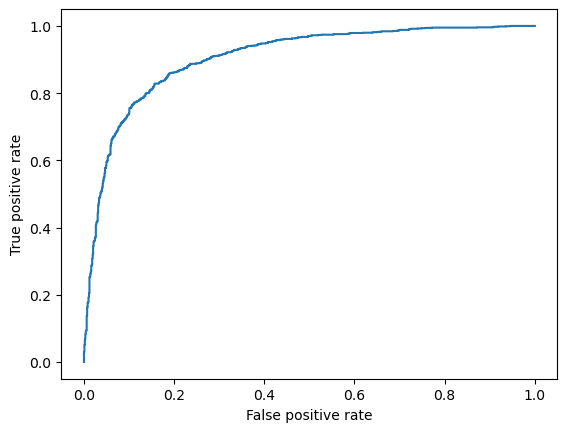

In [31]:
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, predict_proba)

0.9054163758177985

# Подсчет метрик TPR, FPR «вручную»

In [41]:
from collections import Counter

In [44]:
def metrics(y, proba, thres):
    '''
    Возвращает метрики TP, TN, FP, FN.
    y - истинные классы,
    proba - вероятности класса 1,
    thres - пороговое значение.
    '''
    # Первая цифра - предсказание, вторая - класс
    label = {
        (1, 1): 'TP',
        (0, 1): 'FN', 
        (1, 0): 'FP', 
        (0, 0): 'TN'
    }
    predict = [1 if i > thres else 0 for i in proba]
    metrics_ = Counter([label[i] for i in zip(predict, y)])
    return metrics_['TP'], metrics_['TN'], metrics_['FP'], metrics_['FN']

In [51]:
my_metrics = np.array([metrics(y_test, predict_proba, th) for th in np.linspace(0, 1, 100)]) 

In [52]:
my_tpr = my_metrics[:, 0] / (my_metrics[:, 0] + my_metrics[:, 3])
my_fpr = my_metrics[:, 2] / (my_metrics[:, 2] + my_metrics[:, 1])

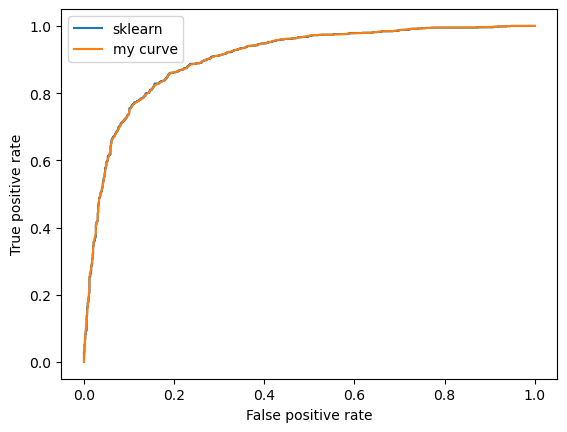

In [53]:
plt.plot(fpr, tpr, label = 'sklearn')
plt.plot(my_fpr, my_tpr, label ='my curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

Идеальное совпадение!

# График Precision-Recall

In [56]:
my_precision = my_metrics[:, 0] / (my_metrics[:, 0] + my_metrics[:, 2]) 
my_recall = my_metrics[:, 0] / (my_metrics[:, 0] + my_metrics[:, 1])

/var/folders/yv/y6gd0q0d7k14thdfy7xxxs140000gn/T/ipykernel_12099/1131709073.py:1: RuntimeWarning: invalid value encountered in divide
  my_precision = my_metrics[:, 0] / (my_metrics[:, 0] + my_metrics[:, 2])


Text(0, 0.5, 'Precision')

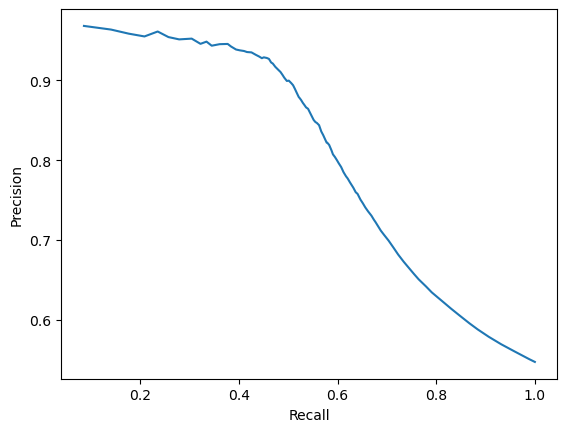

In [59]:
plt.plot(my_recall, my_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')


In [63]:
np.trapz(my_tpr, my_fpr)

-0.9054270687908901

Получилось похоже на sklearn, но почему-то с отрицательным знаком. Не смог разобраться